# Notebook to create a pipeline to analyse the gene to gene attention of cell types for Geneformer finetuned to classify sex of the patient from rna counts.

## workflow : Produce an average attention matrix for each cell type (average of cells belonging to that celltype) and the genes (token_ids). Plot the attention scores in a heatmap for each celltype and attention head. Create a network of genes for each cell type.

### Choosen classifier :  sex classifier
### No of Attention Heads :  6 Head 
### Cell Types :  113

In [2]:
!nvidia-smi

Tue Aug 26 11:38:37 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 12.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:17:00.0 Off |                    0 |
| N/A   30C    P0    48W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:31:00.0 Off |                    0 |
| N/A   

In [5]:
#Importing the necessary libraries
import scanpy as sc
import os
from geneformer import TranscriptomeTokenizer, DataCollatorForCellClassification
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import anndata
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import datasets
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
import torch
import pickle
import numpy as np
from matplotlib.colors import LogNorm, PowerNorm
import networkx as nx

## Create the dataset for attention analysis subset of (1000 cells)
### Dataset balanced for : sex
### Cells : 1000
### Genes : 2048 

In [10]:
train_dataset=datasets.load_from_disk("/hpcfs/users/a1841503/Geneformer/cellnexus/trained_classifiers/sex_classifier_v1_cellnexus/250820181105/sex_classifier_cellnexus_v2_celltype_as_covariate_labeled_train.dataset")
train_dataset

Dataset({
    features: ['input_ids', 'joinid', 'label', 'length'],
    num_rows: 1149732
})

In [9]:
dataset_test=datasets.load_from_disk("/hpcfs/users/a1841503/Geneformer/cellnexus/trained_classifiers/sex_classifier_v1_cellnexus/250820181105/sex_classifier_cellnexus_v2_celltype_as_covariate_labeled_test.dataset")
dataset_test

Dataset({
    features: ['input_ids', 'joinid', 'label', 'length'],
    num_rows: 127748
})

In [12]:
celltype_test_dataset=datasets.load_from_disk("/hpcfs/users/a1841503/Geneformer/cellnexus/data/sex/cell_type/tokenized_combined_data/sex_cell_type.dataset")
celltype_test_dataset

Dataset({
    features: ['input_ids', 'joinid', 'sex', 'cell_type', 'dataset_id', 'length'],
    num_rows: 728682
})

In [ ]:
import scanpy as sc
adata=sc.read_h5ad("/hpcfs/users/a1841503/Geneformer/cellnexus/data/sex/cell_type/combined_anndata_no_unknown.h5ad")

KeyError: "Unable to synchronously open object (object 'obs' doesn't exist)"

### Load The Trained Sex Classifier Model

In [6]:
sex_classifier_model_dir="/hpcfs/users/a1841503/Geneformer/cellnexus/trained_classifiers/sex_classifier_v1_cellnexus/250720190054/250720_geneformer_cellClassifier_sex_classifier_cellnexus/ksplit1/run-e670ee6b/checkpoint-85166"

model_2048 = BertForSequenceClassification.from_pretrained(
    sex_classifier_model_dir,
    num_labels=2 , # or however many classes you have
    ignore_mismatched_sizes=True,
    output_attentions=True
)

In [7]:
model_2048

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(25426, 256, padding_idx=0)
      (position_embeddings): Embedding(2048, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.02, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.02, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (LayerNorm): LayerNorm((256,), eps=1

In [8]:
#plot all the cells in the dataset for each cell type
# Plot frequency of cell types in the dataset

# Get cell type counts - convert list to pandas Series first

cell_type_counts = pd.Series(datset_test['cell_type']).value_counts()

# Create a figure with larger size for better readability
plt.figure(figsize=(18, 12))

# Create bar plot with wider spacing
x_positions = np.arange(len(cell_type_counts)) * 1.2  # Add spacing between bars
bars = plt.bar(x_positions, cell_type_counts.values, width=0.8)

# Customize the plot
plt.title(f'Frequency of Cell Types in Dataset (Total: {len(datset_test):,} cells)', 
          fontsize=16, fontweight='bold')
plt.xlabel('Cell Types', fontsize=12)
plt.ylabel('Number of Cells', fontsize=12)

# Set x-axis labels with rotation and better spacing
plt.xticks(x_positions, cell_type_counts.index, 
           rotation=45, ha='right', fontsize=9)

# Add value labels on top of bars with better formatting
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{int(height):,}', ha='center', va='bottom', fontsize=8, 
             rotation=0, fontweight='bold')

# Adjust layout to prevent label cutoff with more padding
plt.subplots_adjust(bottom=0.25, left=0.1, right=0.95)

# Add grid for better readability
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Set x-axis limits to provide more space
plt.xlim(-0.5, x_positions[-1] + 0.5)

# Show the plot
plt.show()

# Print summary statistics
print(f"\nDataset Summary:")
print(f"Total number of cells: {len(datset_test):,}")
print(f"Number of unique cell types: {len(cell_type_counts)}")
print(f"\nAll cell types:")
for i, (cell_type, count) in enumerate(cell_type_counts.items(), 1):
    print(f"{i:2d}. {cell_type}: {count:,} cells")


NameError: name 'datset_test' is not defined

## Output the attention matrix for the 1k cells 

In [ ]:
training_args = TrainingArguments(       # Already points to ./experiments/{timestamp}/checkpoints              # Already points to ./experiments/{timestamp}/logs
    num_train_epochs=1,
    per_device_train_batch_size=4,        
    per_device_eval_batch_size=4,
    warmup_steps=10,
    weight_decay=0.1,
    logging_steps=50,
    #evaluation_strategy="steps",
    #save_strategy="epoch",
    #load_best_model_at_end=True,
    learning_rate=1e-5,
    gradient_checkpointing=False,                # Using your timestamp-based run name
    report_to=["tensorboard"],
    # Additional suggested parameters that work with your logging:
    metric_for_best_model="eval_loss",
    save_total_limit=2,                 # Only keeps last 2 checkpoints in your checkpoints directory
    fp16=True,
    # Logging specific parameters
    logging_first_step=True,            # Log the first training step
    logging_strategy="steps",           # Log every n steps
)

In [ ]:
token_dict=pickle.load(open("/hpcfs/users/a1841503/Geneformer/geneformer/gene_dictionaries_30m/token_dictionary_gc30M.pkl", "rb"))

trainer_sex = Trainer(
    model=model_2048,
    args=training_args,
    train_dataset=datset_test,
    data_collator=DataCollatorForCellClassification(token_dictionary=token_dict),
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=4)],
)

In [ ]:
# Convert to list first, then use set to get unique values
set(datset_test['cell_type'])
cell_type_value_counts = pd.Series(datset_test['cell_type']).value_counts()

## Plot the average matrix produced

In [ ]:
def _attn_one_cell_raw(trainer, sample):
    model = trainer.model
    model.eval()

    ids = sample['input_ids']
    if isinstance(ids, torch.Tensor):
        ids = ids.tolist()

    input_ids = torch.tensor([ids], dtype=torch.long, device=model.device)
    attention_mask = torch.ones((1, len(ids)), dtype=torch.long, device=model.device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
        mats = []
        for att in outputs.attentions:  # (1, heads, L, L)
            mats.append(att.squeeze(0).mean(0).cpu())  # (L, L)
    return tuple(mats)


def get_overlap_averaged_attentions_by_celltype(trainer, dataset):
    sums = {}
    counts = {}
    tokens_by_ct = {}

    for sample in dataset:
        ct = sample['cell_type']
        ids = sample['input_ids']
        if isinstance(ids, torch.Tensor):
            ids = ids.tolist()

        # Track union of tokens for this cell type (skip pad token 0 if present)
        if ct not in tokens_by_ct:
            tokens_by_ct[ct] = set()
        for t in ids:
            if t != 0:
                tokens_by_ct[ct].add(t)

        mats = _attn_one_cell_raw(trainer, sample)
        if ct not in sums:
            sums[ct] = [dict() for _ in range(len(mats))]
            counts[ct] = [dict() for _ in range(len(mats))]

        L = len(ids)
        for l_idx, mat in enumerate(mats):
            sd = sums[ct][l_idx]
            cd = counts[ct][l_idx]
            for i in range(L):
                ti = ids[i]
                if ti == 0:
                    continue
                for j in range(L):
                    tj = ids[j]
                    if tj == 0:
                        continue
                    key = (ti, tj)
                    val = float(mat[i, j])
                    sd[key] = sd.get(key, 0.0) + val
                    cd[key] = cd.get(key, 0) + 1

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    avg_by_ct = {}
    tokens_list_by_ct = {}
    for ct in sums:
        tok_list = sorted(tokens_by_ct[ct])
        tokens_list_by_ct[ct] = tok_list
        idx = {t: k for k, t in enumerate(tok_list)}
        n = len(tok_list)

        layer_mats = []
        for l_idx in range(len(sums[ct])):
            avg_mat = torch.zeros((n, n), dtype=torch.float32)
            sd = sums[ct][l_idx]
            cd = counts[ct][l_idx]
            for (ti, tj), s in sd.items():
                c = cd[(ti, tj)]
                avg_mat[idx[ti], idx[tj]] = s / c
            layer_mats.append(avg_mat)
        avg_by_ct[ct] = tuple(layer_mats)

    return avg_by_ct, tokens_list_by_ct




In [ ]:
avg_by_ct, tokens_by_ct = get_overlap_averaged_attentions_by_celltype(trainer_sex, datset_test)
# Example: inspect one cell type
ct = next(iter(avg_by_ct))
avg_mats = avg_by_ct[ct]           # tuple of layers
tokens = tokens_by_ct[ct]
# list of token ids for each cell type

In [ ]:
# Save the attention matrices to disk
# Define the save directory
save_dir = "/hpcfs/users/a1841503/Geneformer/cellnexus/data/sex/cell_type/attention_outputs/"
os.makedirs(save_dir, exist_ok=True)

# Save as pickle file
save_path = os.path.join(save_dir, "celltype_attention_matrices_averaged_geneformer_sex_classifier.pkl")
with open(save_path, 'wb') as f:
    pickle.dump(avg_by_ct)
    
print(f"Averaged Attention matrices saved to: {save_path}")

save_path = os.path.join(save_dir, "tokensids_celltype_attention_matrices_geneformer_sex_classifier.pkl")
with open(save_path, 'wb') as f:
    pickle.dump(tokens_by_ct, f)
    
print(f"Tokens ids of Celltype Attention matrices saved to: {save_path}")




In [ ]:
!scancel 5496328

In [16]:
import pickle
avg_by_ct= pickle.load(open("/hpcfs/users/a1841503/Geneformer/cellnexus/data/sex/cell_type/attention_outputs/celltype_attention_matrices.pkl", "rb"))
#tokens_by_ct = pickle.load(open("/hpcfs/users/a1841503/Geneformer/cellnexus/data/sex/cell_type/attention_outputs/celltype_input_ids.pkl", "rb"))


In [17]:
import pickle
tokens_by_ct = pickle.load(open("/hpcfs/users/a1841503/Geneformer/cellnexus/data/sex/cell_type/attention_outputs/celltype_input_ids.pkl", "rb"))

In [18]:
avg_by_ct

{'natural killer cell': (tensor([[0.0175, 0.0113, 0.0048,  ..., 0.0003, 0.0003, 0.0003],
          [0.0176, 0.0195, 0.0249,  ..., 0.0003, 0.0003, 0.0002],
          [0.0049, 0.0230, 0.0257,  ..., 0.0003, 0.0003, 0.0002],
          ...,
          [0.0011, 0.0009, 0.0008,  ..., 0.0096, 0.0097, 0.0117],
          [0.0011, 0.0008, 0.0008,  ..., 0.0116, 0.0098, 0.0101],
          [0.0010, 0.0008, 0.0007,  ..., 0.0139, 0.0111, 0.0087]]),
  tensor([[3.8421e-03, 3.6046e-03, 3.2471e-03,  ..., 5.9881e-05, 8.0088e-05,
           1.0228e-04],
          [4.0100e-03, 3.6722e-03, 3.3209e-03,  ..., 5.3979e-05, 7.0882e-05,
           9.0161e-05],
          [3.8224e-03, 3.6335e-03, 3.4661e-03,  ..., 5.1025e-05, 6.5778e-05,
           8.5393e-05],
          ...,
          [1.5900e-03, 1.2359e-03, 1.2019e-03,  ..., 2.2665e-04, 1.1413e-03,
           1.1983e-03],
          [1.9002e-03, 1.4375e-03, 1.3858e-03,  ..., 8.5362e-05, 3.0433e-04,
           1.1474e-03],
          [1.8423e-03, 1.4772e-03, 1.4414e-0

In [ ]:
# Plot the first cell type's multi-head attention using avg_by_ct variable


# Get the first cell type from avg_by_ct
first_cell_type = list(avg_by_ct.keys())[0]
print(f"Plotting attention for cell type: {first_cell_type}")

# Get the attention data for the first cell type
cell_type_data = avg_by_ct[first_cell_type]



Plotting attention for cell type: natural killer cell


In [21]:
first_cell_type

'natural killer cell'

Number of attention heads: 6


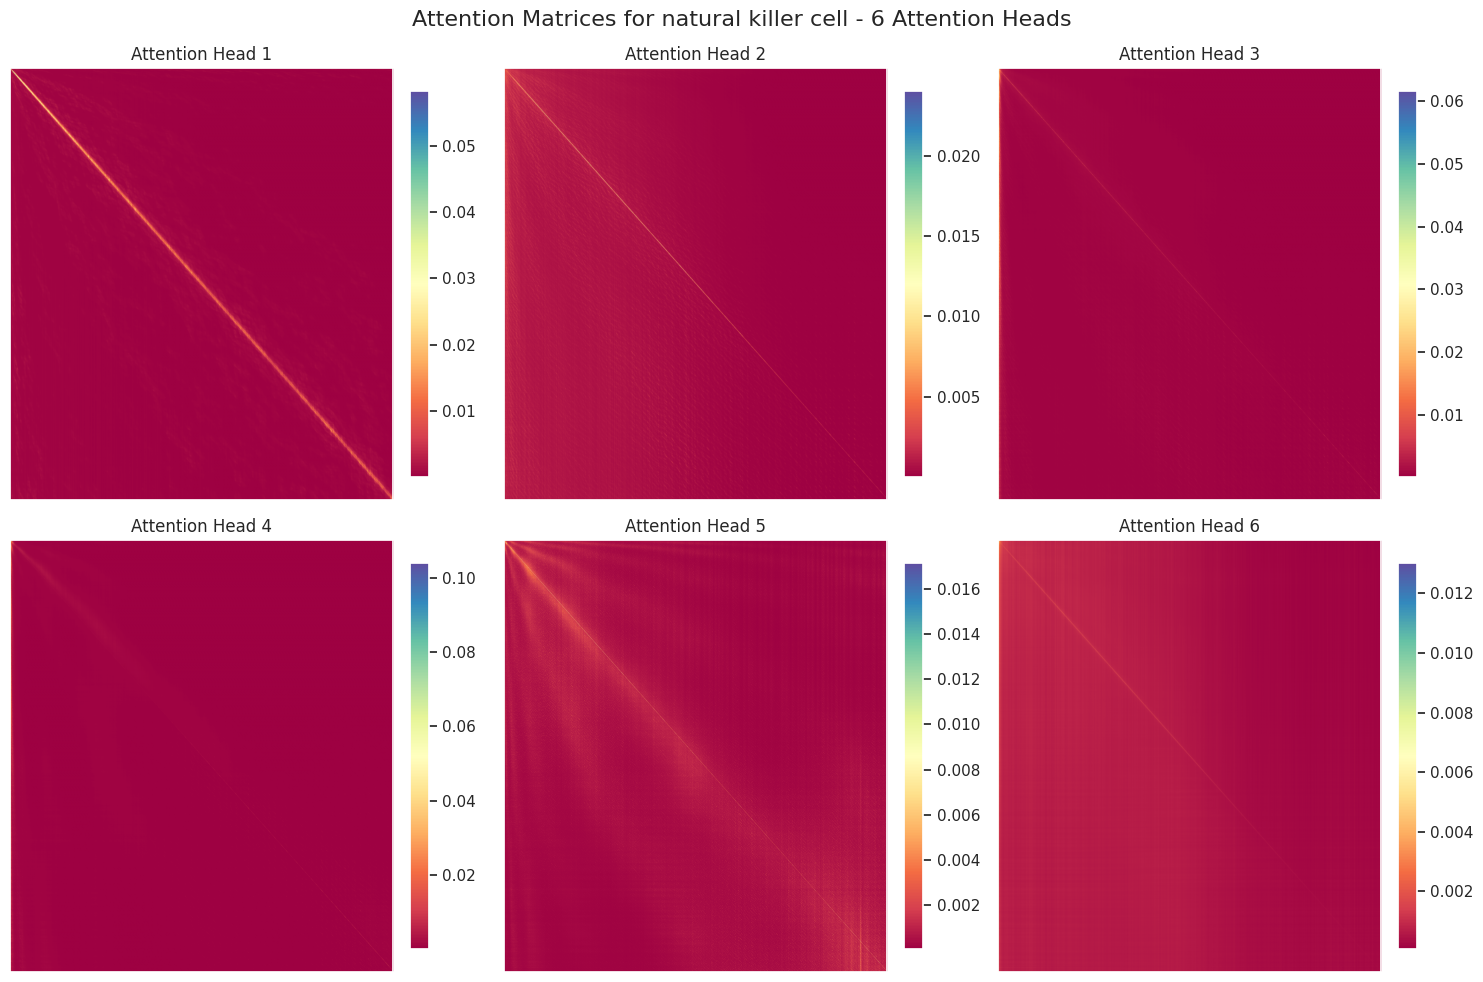

(tensor([[0.0175, 0.0113, 0.0048,  ..., 0.0003, 0.0003, 0.0003],
         [0.0176, 0.0195, 0.0249,  ..., 0.0003, 0.0003, 0.0002],
         [0.0049, 0.0230, 0.0257,  ..., 0.0003, 0.0003, 0.0002],
         ...,
         [0.0011, 0.0009, 0.0008,  ..., 0.0096, 0.0097, 0.0117],
         [0.0011, 0.0008, 0.0008,  ..., 0.0116, 0.0098, 0.0101],
         [0.0010, 0.0008, 0.0007,  ..., 0.0139, 0.0111, 0.0087]]),
 tensor([[3.8421e-03, 3.6046e-03, 3.2471e-03,  ..., 5.9881e-05, 8.0088e-05,
          1.0228e-04],
         [4.0100e-03, 3.6722e-03, 3.3209e-03,  ..., 5.3979e-05, 7.0882e-05,
          9.0161e-05],
         [3.8224e-03, 3.6335e-03, 3.4661e-03,  ..., 5.1025e-05, 6.5778e-05,
          8.5393e-05],
         ...,
         [1.5900e-03, 1.2359e-03, 1.2019e-03,  ..., 2.2665e-04, 1.1413e-03,
          1.1983e-03],
         [1.9002e-03, 1.4375e-03, 1.3858e-03,  ..., 8.5362e-05, 3.0433e-04,
          1.1474e-03],
         [1.8423e-03, 1.4772e-03, 1.4414e-03,  ..., 4.3162e-05, 9.3244e-05,
         

In [23]:
# Plot the 6 attention head matrices for the first cell type
import matplotlib.pyplot as plt
import numpy as np

# Get the 6 attention matrices for the first cell type
attention_matrices = cell_type_data

print(f"Number of attention heads: {len(attention_matrices)}")

# Create a 2x3 subplot grid to display all 6 attention head matrices
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle(f'Attention Matrices for {first_cell_type} - 6 Attention Heads', fontsize=16)

# Plot each attention head matrix
for i, matrix in enumerate(attention_matrices):
    row = i // 3
    col = i % 3
    
    # Convert tensor to numpy if needed
    if hasattr(matrix, 'numpy'):
        matrix_np = matrix.numpy()
    else:
        matrix_np = matrix
    
    # Plot the attention matrix
    im = axes[row, col].imshow(matrix_np, cmap='Spectral', aspect='auto')
    axes[row, col].set_title(f'Attention Head {i+1}')
    axes[row, col].set_xticks([])
    axes[row, col].set_yticks([])
    
    # Add colorbar for each subplot
    plt.colorbar(im, ax=axes[row, col], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Also display the raw data
cell_type_data

In [ ]:
# Set up spectral color palette similar to ggplot2's scale_color_brewer(type="seq", palette="Spectral")
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import torch

# Create spectral palette similar to ggplot2's ColorBrewer Spectral
spectral_colors = ['#9e0142', '#d53e4f', '#f46d43', '#fdae61', '#fee08b', 
                   '#e6f598', '#abdda4', '#66c2a5', '#3288bd', '#5e4fa2']
spectral_cmap = ListedColormap(spectral_colors)

# Set this as default colormap for plotting
plt.rcParams['image.cmap'] = 'Spectral'

In [ ]:
# Plot gene-to-gene attention per cell type from avg_by_ct using Spectral palette


def plot_avg_gene_attention(avg_by_ct, tokens_list_by_ct, average_across_layers=True, layer_idx=0, max_tokens=2048):
    if not avg_by_ct:
        print("avg_by_ct is empty. Run get_overlap_averaged_attentions_by_celltype first.")
        return

    use_cmap = spectral_cmap if 'spectral_cmap' in globals() else 'Spectral'

    for ct, mats in avg_by_ct.items():
        tokens = tokens_list_by_ct[ct]
        
        if average_across_layers:
            # Average across all layers/heads - single plot
            mat = torch.stack(mats).mean(dim=0).numpy()
            
            if max_tokens is not None:
                mat = mat[:max_tokens, :max_tokens]
                tokens = tokens[:max_tokens]

            plt.figure(figsize=(8, 6))
            im = plt.imshow(mat, cmap=use_cmap, aspect='auto')
            plt.title(f'{ct} gene-to-gene attention (averaged across layers)')
            plt.xlabel('token id')
            plt.ylabel('token id')
            plt.colorbar(im, label='Attention')

        if len(tokens) <= 50:
            plt.xticks(range(len(tokens)), tokens, rotation=90, fontsize=6)
            plt.yticks(range(len(tokens)), tokens, fontsize=6)
        else:
            plt.xticks([])
            plt.yticks([])

            plt.tight_layout()
            plt.show()
        else:
            # Plot separate heads in a grid for each cell type
            num_layers = len(mats)
            cols = min(4, num_layers)  # Max 4 columns
            rows = (num_layers + cols - 1) // cols
            
            fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
            if num_layers == 1:
                axes = [axes]
            elif rows == 1:
                axes = [axes]
            else:
                axes = axes.flatten()
            
            fig.suptitle(f'{ct} gene-to-gene attention by layer/head', fontsize=16)
            
            for i, mat in enumerate(mats):
                mat_np = mat.numpy()
                
                if max_tokens is not None:
                    mat_np = mat_np[:max_tokens, :max_tokens]
                    tokens_plot = tokens[:max_tokens]
                else:
                    tokens_plot = tokens
                
                ax = axes[i] if num_layers > 1 else axes[0]
                im = ax.imshow(mat_np, cmap=use_cmap, aspect='auto')
                ax.set_title(f'Layer/Head {i}')
                ax.set_xlabel('token id')
                ax.set_ylabel('token id')
                
                if len(tokens_plot) <= 20:  # Fewer tokens for grid view
                    ax.set_xticks(range(len(tokens_plot)))
                    ax.set_xticklabels(tokens_plot, rotation=90, fontsize=4)
                    ax.set_yticks(range(len(tokens_plot)))
                    ax.set_yticklabels(tokens_plot, fontsize=4)
                else:
                    ax.set_xticks([])
                    ax.set_yticks([])
            
            # Hide empty subplots
            for i in range(num_layers, len(axes)):
                axes[i].set_visible(False)
            
            plt.tight_layout()
            plt.show()


# Quick run helper (uncomment after computing avg_by_ct/tokens_list_by_ct)
# if 'avg_by_ct' in locals() and 'tokens_list_by_ct' in locals() and avg_by_ct:
#     plot_avg_gene_attention(avg_by_ct, tokens_list_by_ct, average_across_layers=True, max_tokens=100)
# else:
#     print('avg_by_ct or tokens_list_by_ct not found. Run get_overlap_averaged_attentions_by_celltype first.')


## Build a gene network, thresholding on min attention value.

In [ ]:
plot_avg_gene_attention(avg_by_ct, tokens_by_ct, average_across_layers=True, max_tokens=2048)

In [9]:
# e.g., layer 0
plot_gene_attention_per_head(avg_by_ct, tokens_by_ct, layer_idx=0, max_tokens=2048)

NameError: name 'plot_gene_attention_per_head' is not defined

In [8]:
plot_layers_heads_grid_by_celltype(avg_by_ct, tokens_by_ct, max_tokens=2048)

NameError: name 'tokens_by_ct' is not defined

In [ ]:
# Create an empty graph
G = nx.Graph()

# Add nodes to the graph
for tokens_by_ct in KB.keys():
    G.add_node(entity)

# Add edges to the graph
for entity, relationships in KB.items():
    for related_entity in relationships:
        G.add_edge(entity, related_entity)

# Draw the graph
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=300)
nx.draw_networkx_edges(G, pos, width=1)
nx.draw_networkx_labels(G, pos, font_size=12, font_family="serif")
plt.axis("off")
plt.show()